In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [10]:
# Define variables
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [11]:
# Import image data to tf dataset variable
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'tomato1',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32
)

class_names = dataset.class_names

# Display the number of files in each class
file_counts = [len(glob.glob(f'tomato1/{class_name}/*')) for class_name in class_names]
for class_name, count in zip(class_names, file_counts):
    print(f"Class: {class_name}, Files: {count}")


Found 8660 files belonging to 5 classes.
Class: Tomato_Early_blight, Files: 1000
Class: Tomato_Late_blight, Files: 1909
Class: Tomato_Leaf_Mold, Files: 952
Class: Tomato__Tomato_YellowLeaf__Curl_Virus, Files: 3209
Class: Tomato_healthy, Files: 1591


In [12]:
# Function to split data into train, test, and validation data
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [13]:
# Create dataset pipeline
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
# Resize and scale image data
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])


In [15]:
# Placing pooling, convolutional, dense, and other layers in sequential layer
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [16]:
# Training the model
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
216/216 [==============================] - 121s 521ms/step - loss: 0.9161 - accuracy: 0.6510 - val_loss: 0.3810 - val_accuracy: 0.8576
Epoch 2/10
216/216 [==============================] - 120s 556ms/step - loss: 0.4260 - accuracy: 0.8454 - val_loss: 0.2825 - val_accuracy: 0.8947
Epoch 3/10
216/216 [==============================] - 103s 476ms/step - loss: 0.3037 - accuracy: 0.8868 - val_loss: 0.2297 - val_accuracy: 0.9109
Epoch 4/10
216/216 [==============================] - 105s 486ms/step - loss: 0.2524 - accuracy: 0.9129 - val_loss: 0.1904 - val_accuracy: 0.9329
Epoch 5/10
216/216 [==============================] - 103s 479ms/step - loss: 0.1973 - accuracy: 0.9310 - val_loss: 0.1587 - val_accuracy: 0.9375
Epoch 6/10
216/216 [==============================] - 105s 484ms/step - loss: 0.1778 - accuracy: 0.9397 - val_loss: 0.1960 - val_accuracy: 0.9225
Epoch 7/10
216/216 [==============================] - 101s 468ms/step - loss: 0.1617 - accuracy: 0.9416 - val_loss: 0.1046 -

In [17]:
# Evaluate the model on the test dataset
model.evaluate(test_ds)


28/28 [==============================] - 11s 149ms/step - loss: 0.0478 - accuracy: 0.9821


[0.04783635586500168, 0.9821428656578064]

In [18]:
# Predicting from the model
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    batch_predictions = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(labels_batch.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 0s 160ms/step


In [19]:
# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[119   5   1   1   0]
 [  3 195   0   0   0]
 [  0   3  92   0   0]
 [  1   0   0 304   0]
 [  1   1   0   0 170]]


In [20]:
# Classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                                       precision    recall  f1-score   support

                  Tomato_Early_blight       0.96      0.94      0.95       126
                   Tomato_Late_blight       0.96      0.98      0.97       198
                     Tomato_Leaf_Mold       0.99      0.97      0.98        95
Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      1.00      1.00       305
                       Tomato_healthy       1.00      0.99      0.99       172

                             accuracy                           0.98       896
                            macro avg       0.98      0.98      0.98       896
                         weighted avg       0.98      0.98      0.98       896



In [21]:
# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.9821428571428571


In [22]:
# Calculate metrics per class
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

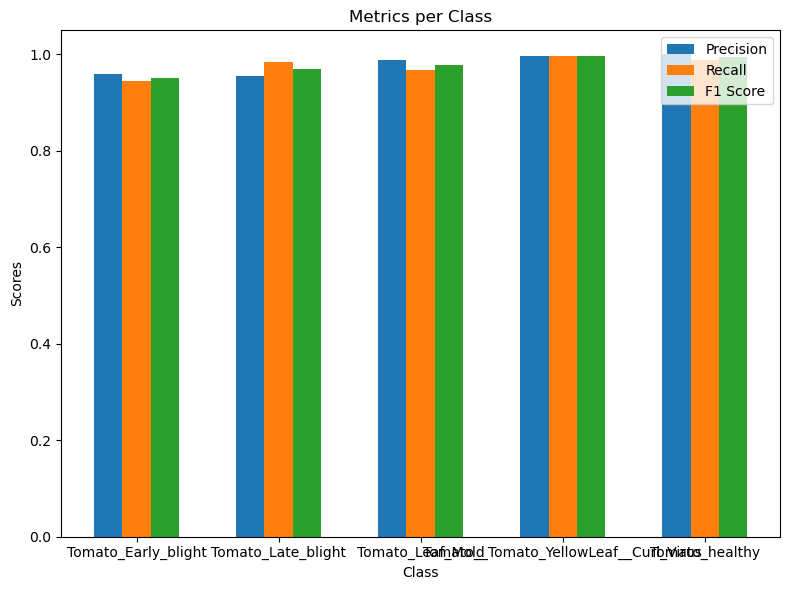

In [23]:
# Display metrics per class in graph form
x = np.arange(len(class_names))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Metrics per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

fig.tight_layout()
plt.show()

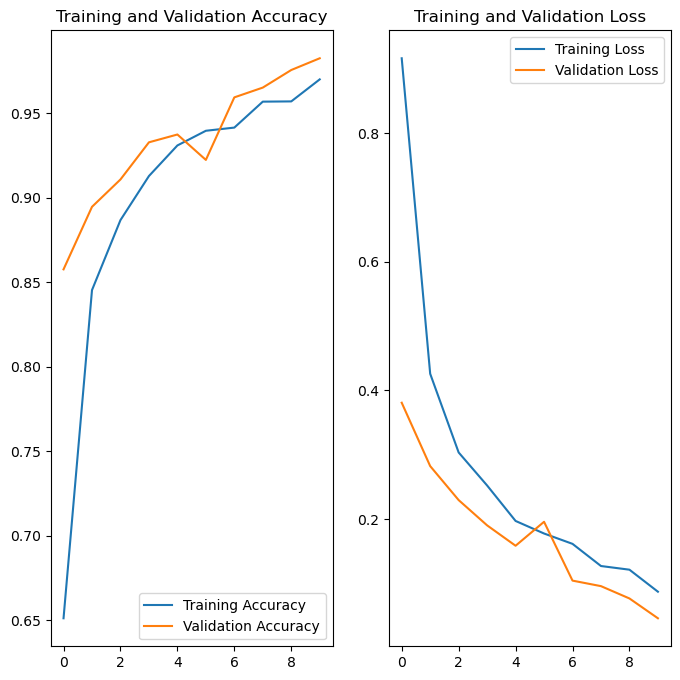

In [24]:
# Plotting graphs
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Predicting from the model
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


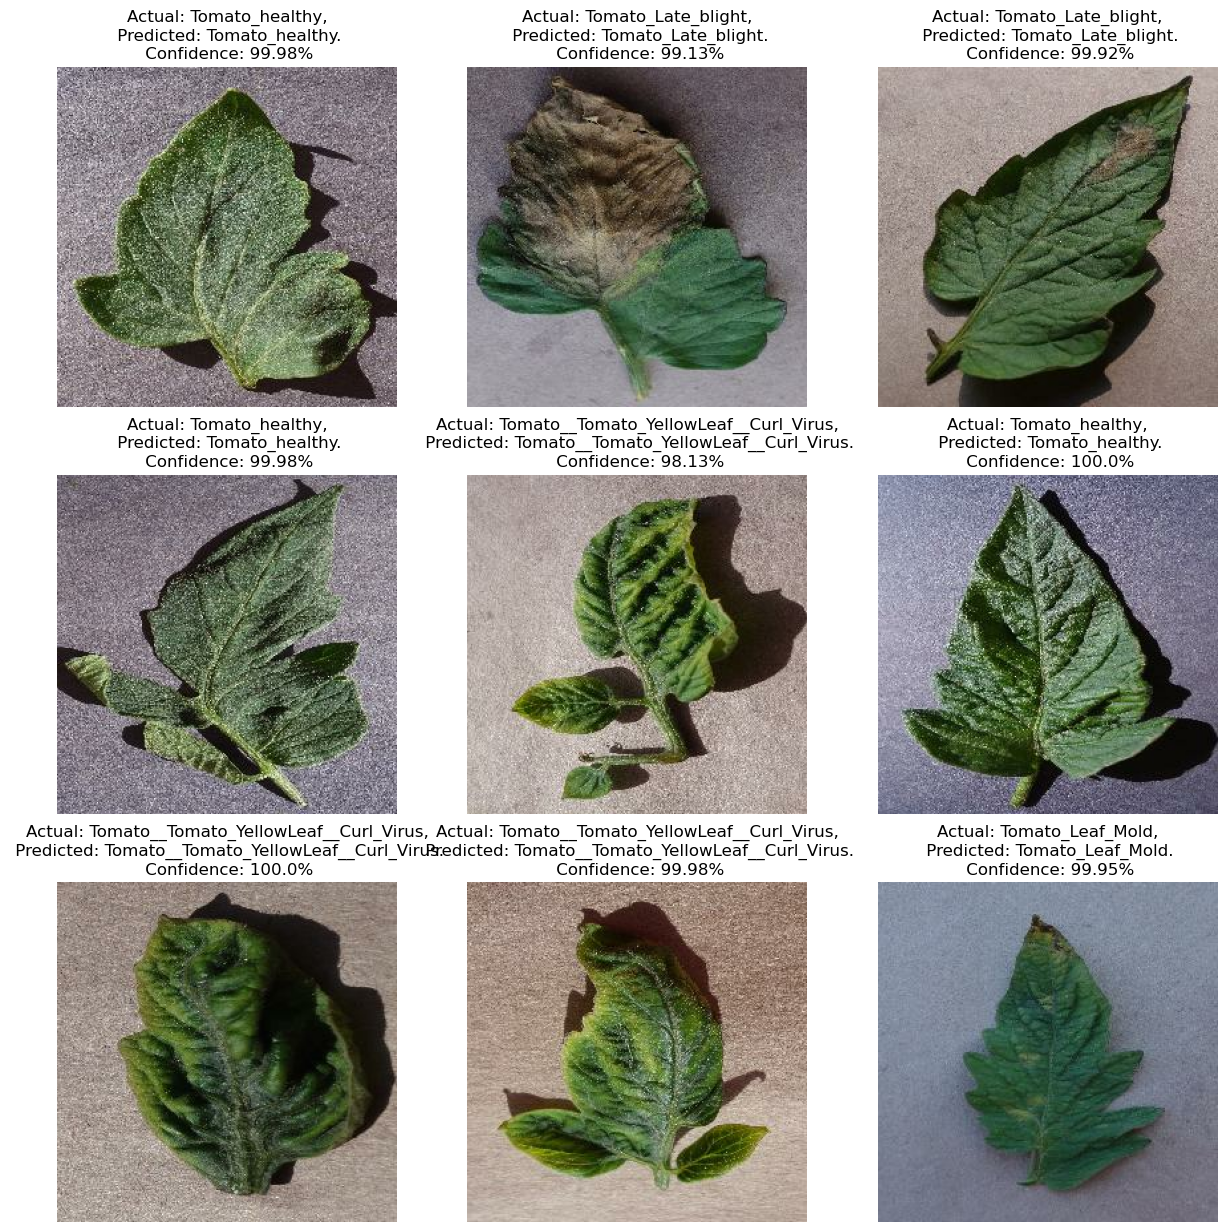

In [26]:
# Plot more predictions with images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [27]:
# Save the model
model.save("tdcm2.h5")